<center>

# __Kernel-based Quantum Machine Learning__

November 14, 2023

<br>

__Computación Cuántica y Aprendizaje Máquina__

__Máster en Ciencia y Tecnologías de Información Cuántica (MQIST)__

<br>

Diego Alvarez-Estevez, PhD.

_Centro de Investigación en Tecnologías de la Información y las Comunicaciones (CITIC)_

_Universidade da Coruña_

</center>

## Overview

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this notebook, you will learn how to define quantum kernels using `qiskit-machine-learning` and how these can be plugged into different algorithms to solve classification and clustering problems.

All examples used in this tutorial are based on this reference paper: [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf).

The content is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Classification](#2.-Classification)
3. [Kernel Principal Components Analysis](#3.-Kernel-Principal-Component-Analysis)
4. [Conclusions](#4.-Conclusion)
5. [Exercises](#5.-Exercises)

## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering or dimensionality reduction.

### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $d$-dimensional inputs
* $f$ is a map from $d$-dimension to $d_f$-dimension space (usually $d_f >> d$) and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $d$-dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or kPCA algorithms, as you will see in the examples below.

## 2. Classification

This section illustrates a quantum kernel classification workflow using [qiskit-machine-learning](https://github.com/qiskit-community/qiskit-machine-learning).

### 2.0. Basic setup:

Installation of all required Python libraries and most of related dependencies for running this notebook should be handled automatically with installation of the ```qiskit-machine-learning``` package using the following command:

**_pip install qiskit-machine-learning_**

For visualization rutines and better integration with Jupyter notebooks it is recommended that you also run the following command:

**_pip install qiskit[visualization]_**

In particular, check that you have installed a version of the Qiskit package (at least version >= 0.44), ```qiskit-machine-learning``` package (version >= 0.6.0) and ```qiskit-algorithms``` (version >= 0.20).

Otherwise proceed to install the required packages individually

In [1]:
# Version checking
import qiskit.tools.jupyter
import qiskit_machine_learning
import qiskit

%qiskit_version_table

Also, before proceeding, we set up the global seed to ensure reproducibility:

In [2]:
from qiskit.utils import algorithm_globals 

algorithm_globals.random_seed = 12345

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20, # for each class, thus 40 in total
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    #plot_data=True,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: _A_ and _B_. We can plot it and see what the distribution looks like. We define utility functions to plot the dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

Now we actually plot the dataset for classification:

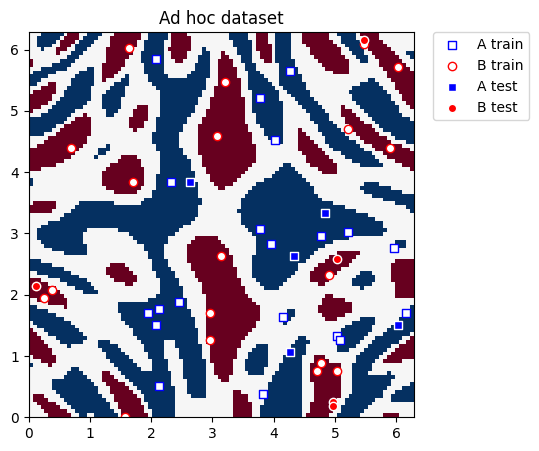

In [5]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the [FidelityQuantumKernel](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html).

2. `fidelity`: in this case, the [ComputeUncompute](https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.ComputeUncompute.html) fidelity subroutine that leverages the [Sampler](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html) primitive.

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [5]:
from qiskit.circuit.library import ZZFeatureMap
# Using Qiskit Terra's Sampler reference, use Aer / QiskitRuntime for improved performance
# More information: https://medium.com/qiskit/introducing-qiskit-machine-learning-0-6-25186b57bf97
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

/tmp/ipykernel_5803/4148063873.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [6]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

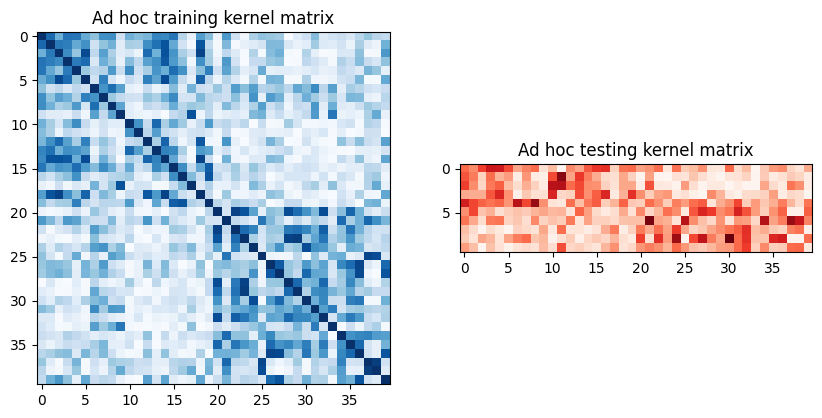

In [8]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [9]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [10]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


### 2.5. Evaluation of models used for classification

In [11]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
SVC using kernel as a callable function |       1.00
SVC using precomputed kernel matrix     |       1.00
QSVC                                    |       1.00


As the classification dataset is small, we find that the three models achieve 100% accuracy.

## 3. Kernel Principal Component Analysis

This section focuses on a Principal Component Analysis task using a kernel PCA algorithm. We calculate a kernel matrix using a `ZZFeatureMap` and show that this approach translates the original features into a new space, where axes are chosen along principal components. In this space the classification task can be performed with a simpler model rather than an SVM.

### 3.1. Defining the dataset

We again use the _ad hoc dataset_, but now generated with a higher gap of `0.6` (previous example: `0.3`) between the two classes.

In [12]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=10,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

We plot the training and test datasets below. Our ultimate goal in this section is to construct new coordinates where the two classes can be linearly separated.

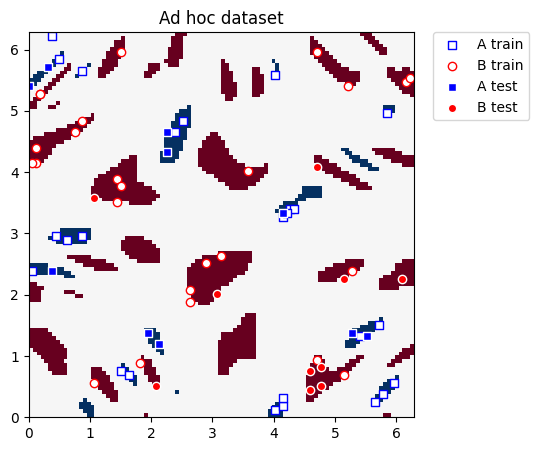

In [13]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 3.2. Defining the Quantum Kernel

We proceed with the same kernel setup as it was in the classification task, namely a `ZZFeatureMap` circuit as a feature map and an instance of `FidelityQuantumKernel`. You might notice that in this case we do not provide a `fidelity` instance. This is because the `ComputeUncompute` method provided in the previous case is instantiated by default when the fidelity instance is not provided explicitly.

In [11]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
#qpca_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
qpca_kernel = FidelityQuantumKernel(feature_map=feature_map) # ComputeUncompute method using built-in Sampler initialized by default

Then, we evaluate kernel matrices for the training and test features.

In [15]:
k_matrix_train = qpca_kernel.evaluate(x_vec=train_features)
k_matrix_test = qpca_kernel.evaluate(x_vec=test_features, y_vec=train_features)

### 3.3. Comparison of Kernel PCA on gaussian and quantum kernel

In this section we use the `KernelPCA` implementation from `scikit-learn`, with the `kernel` parameter set to "rbf" for a gaussian kernel and "precomputed" for a quantum kernel. The former is a very popular kernel function used in classical machine learning models, whereas the latter allows us to use a quantum kernel using its associated precomputed kernel matrix, which we have previously instantiated using `qpca_kernel`.

In [16]:
from sklearn.decomposition import KernelPCA

kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_rbf.fit(train_features)
train_features_rbf = kernel_pca_rbf.transform(train_features)
test_features_rbf = kernel_pca_rbf.transform(test_features)

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
kernel_pca_q.fit(k_matrix_train)
train_features_q = kernel_pca_q.transform(k_matrix_train)
test_features_q = kernel_pca_q.transform(k_matrix_test)

While usually PCA is used to reduce the number of features in a dataset, or in other words to reduce dimensionality of a dataset, we don't do that here. Instead, we keep the number of dimensions and employ the kernel PCA, mostly for visualization purposes, to show that classification on the transformed dataset becomes easily tractable by linear methods, like logistic regression. We use this method to separate two classes in the principal component space with a `LogisticRegression` model from `scikit-learn`. As usual we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

Here we train and score a model.

In [12]:
from sklearn.linear_model import LogisticRegression

# Using classical RBF kPCA preprocessing
logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_rbf, train_labels)

logistic_score = logistic_regression.score(train_features_rbf, train_labels)
print(f"Logistic regression (rbf kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_rbf, test_labels)
print(f"Logistic regression (rbf kPCA preprocessed) test score: {logistic_score}")

# Using Quantum kPCA preprocessing
logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, train_labels)

logistic_score = logistic_regression.score(train_features_q, train_labels)
print(f"Logistic regression (Quantum kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_q, test_labels)
print(f"Logistic regression (Quantum kPCA preprocessed) test score: {logistic_score}")

NameError: name 'train_features_rbf' is not defined

One can observe that the gaussian kernel based Kernel PCA model fails to make the dataset linearly separable, while the quantum kernel succeeds.

Let's plot the results. First, we plot the transformed dataset we get with the quantum kernel. On the same plot we also add model results. Then, we plot the transformed dataset we get with the gaussian kernel.

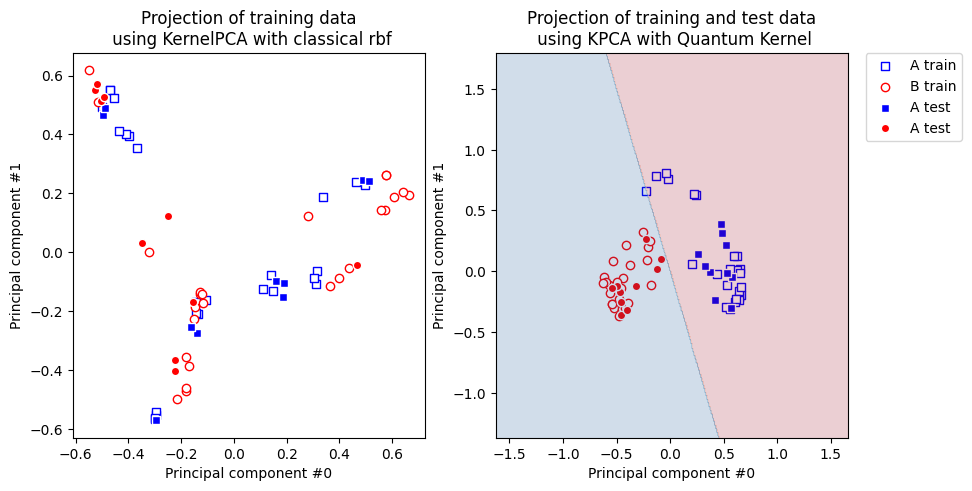

In [18]:
fig, (rbf_ax, q_ax) = plt.subplots(1, 2, figsize=(10, 5))

plot_features(q_ax, train_features_q, train_labels, 0, "s", "w", "b", "A train")
plot_features(q_ax, train_features_q, train_labels, 1, "o", "w", "r", "B train")
plot_features(q_ax, test_features_q, test_labels, 0, "s", "b", "w", "A test")
plot_features(q_ax, test_features_q, test_labels, 1, "o", "r", "w", "A test")

q_ax.set_ylabel("Principal component #1")
q_ax.set_xlabel("Principal component #0")
q_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = train_features_q[:, 0].min() - 1, train_features_q[:, 0].max() + 1
y_min, y_max = train_features_q[:, 1].min() - 1, train_features_q[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
q_ax.contourf(xx, yy, predictions, cmap=plt.cm.RdBu, alpha=0.2)

# Now classical RBF kernel
plot_features(rbf_ax, train_features_rbf, train_labels, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, train_features_rbf, train_labels, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, test_features_rbf, test_labels, 0, "s", "b", "w", "A test")
plot_features(rbf_ax, test_features_rbf, test_labels, 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
#rbf_ax.set_title("Projection of training data\n using KernelPCA")
rbf_ax.set_title("Projection of training data\n using KernelPCA with classical rbf")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

As we can see, the data points on the left figure are not linearly separable, but they are on the right one. Hence in case of quantum kernel we can apply linear models on the transformed dataset and this is why SVM classifier works perfectly well on the _ad hoc_ dataset as we saw in the [classification section](#2.-Classification).

## 4. Conclusions

In this tutorial:

* We reviewed the fundamentals of quantum kernel learning
* We understood how to define quantum kernels as instances of `FidelityQuantumKernel`
* We learned how to use the `scikit-learn` `SVC` algorithm with a custom quantum kernel as a callable function vs precomputed quantum kernel matrix for classification
* We learned how to train classifiers with the `QSVC` algorithm from `qiskit-machine-learning`
* We investigated how to plug in a quantum kernel into `scikit-learn`'s `KernelPCA` algorithm and transform the ad-hoc dataset into a new one that can be tackled by a linear model.

For further reference, `scikit-learn` has other algorithms that can use a precomputed kernel matrix, such as:

- [Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)
- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Gaussian process regression](https://scikit-learn.org/stable/modules/gaussian_process.html)

## 5. Exercises

Now it your turn.

Up to now all experiments were based on data extracted from the custom ad-hoc dataset. We will consider now a more realistic experimental scenario for which your tasks will consist of:

1. Pick one reference classification dataset other than ad-hoc. You might consider one of the several built-in possibilities included within [Scikit-learn](https://scikit-learn.org/stable/datasets.html) or download it from other well-known public repositories such as [UCI](https://archive.ics.uci.edu/datasets) or [Kaggle](https://www.kaggle.com/datasets). Split the chosen dataset into train and test partitions with respective 80%-20% propotion. 

In [8]:
# Fill in here with your code and discussion
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

data =load_breast_cancer()

X = data.data
y = data.target
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)





2. Rearrange the dataset by selecting 2 out of the $n$ original features and plot the resulting data. Train both classical and quantum SVM models using the training data. Use an RBF kernel for the classical model and let default parameterization for $sigma$ and $C$. Use the same ZZFeatureMap described above in the case of the quantum kernel. Calculate and plot the associated kernel matrices, and report the corresponding performance in both the training and test partitions. Discuss and compare the results.

In [9]:
# Fill in here with your code and discussion
selected_features = [0,7]
X_train = X_train[:,selected_features]
X_test = X_test[:,selected_features]
X0, X1 = X_train[:, 0], X_train[:, 1]



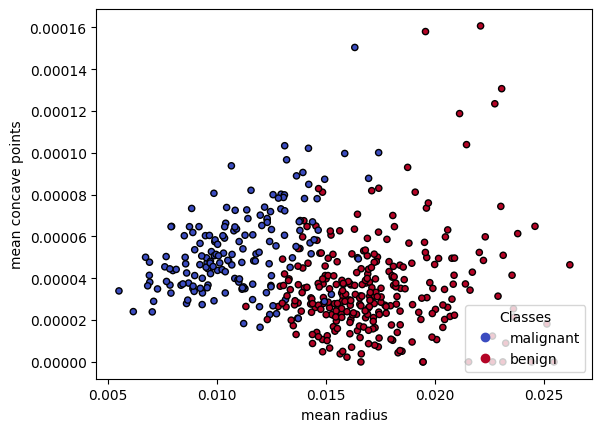

In [12]:
_, ax = plt.subplots()

scatter = ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set(xlabel=data.feature_names[selected_features[0]], ylabel=data.feature_names[selected_features[1]])
_ = ax.legend(
    scatter.legend_elements()[0], data.target_names, loc="lower right", title="Classes"
)

In [13]:
#Primero vamos a entrenar el SVC
from sklearn.svm import SVC

SVM = SVC().fit(X_train,y_train)

y_pred = SVM.predict(X_train)

print("Score de training: ",SVM.score(X_train,y_train))
print("Score de test: ",SVM.score(X_test,y_test))
#Ahora el SVC Quantico




Score de training:  0.9142857142857143
Score de test:  0.9473684210526315


Kernel Matrix:
[[1.         0.99991631 0.99999983 ... 0.99998031 0.99996519 0.9999892 ]
 [0.99991631 1.         0.99990857 ... 0.9999778  0.99998945 0.99996563]
 [0.99999983 0.99990857 1.         ... 0.99997647 0.99996013 0.99998631]
 ...
 [0.99998031 0.9999778  0.99997647 ... 1.         0.99999786 0.99999867]
 [0.99996519 0.99998945 0.99996013 ... 0.99999786 1.         0.99999316]
 [0.9999892  0.99996563 0.99998631 ... 0.99999867 0.99999316 1.        ]]


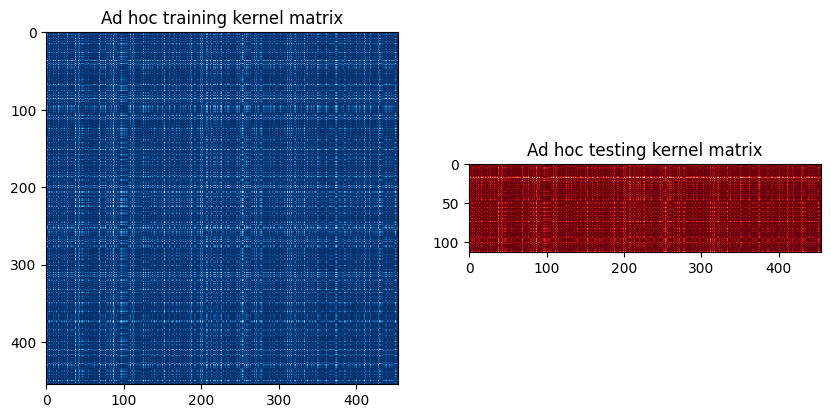

In [18]:

### FALTA MATRIZ DEL KERNEL CLASICO
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_kernels

support_vectors = SVM.support_vectors_


kernel_matrix_train = rbf_kernel(X_train)

kernel_matrix_test = rbf_kernel(X_test, X_train)

# Print the kernel matrix
print("Kernel Matrix:")
print(kernel_matrix_train)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    kernel_matrix_train, interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(kernel_matrix_test, interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

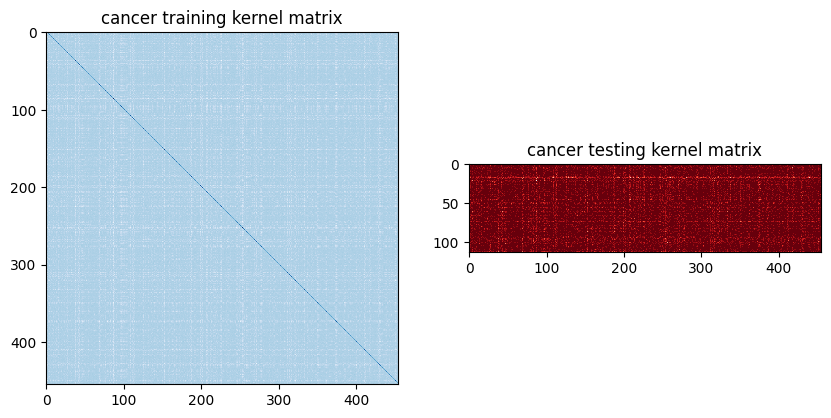

In [24]:
from qiskit.circuit.library import ZZFeatureMap
# Using Qiskit Terra's Sampler reference, use Aer / QiskitRuntime for improved performance
# More information: https://medium.com/qiskit/introducing-qiskit-machine-learning-0-6-25186b57bf97
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
cancer_dimension = 2
cancer_feature_map = ZZFeatureMap(feature_dimension=cancer_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

cancer_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=cancer_feature_map)

cancer_matrix_train = cancer_kernel.evaluate(x_vec=X_train)
cancer_matrix_test = cancer_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(cancer_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("cancer training kernel matrix")

axs[1].imshow(np.asmatrix(cancer_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("cancer testing kernel matrix")

plt.show()


In [25]:
cancer_svc = SVC(kernel="precomputed")

cancer_svc.fit(cancer_matrix_train, y_train)

cancer_score_precomputed_kernel_test = cancer_svc.score(cancer_matrix_test, y_test)
cancer_score_precomputed_kernel_train = cancer_svc.score(cancer_matrix_train, y_train)

print(f"Precomputed kernel classification train score: {cancer_score_precomputed_kernel_train}")
print(f"Precomputed kernel classification test score: {cancer_score_precomputed_kernel_test}")

Precomputed kernel classification train score: 0.6285714285714286
Precomputed kernel classification test score: 0.6228070175438597


3. Using the same 2-feature dataset train now a classical logistic regression model and report the associated train and test performances. Apply now kernel PCA to transform the data into new features as seen in the tutorial above, and train two additional logistic regression models, respectively again, to compare classical RBF and quantum ZZFeatureMap-based feature mappings. Report achieved performances on the training and test partitions for each of the three resulting scenarios.

In [26]:
# Fill in here with your code and discussion
#Primero vamos a ver que resultados da la regresión logística por si sola.
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression().fit(X_train,y_train)

print("Score: ",LR.score(X_train,y_train))
print("Score: ",LR.score(X_test,y_test))



Score:  0.6285714285714286
Score:  0.6228070175438597


In [27]:
#Ahora vamos a calcular las features tras la PCA.

from sklearn.decomposition import KernelPCA

kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_rbf.fit(X_train)
train_features_rbf = kernel_pca_rbf.transform(X_train)
test_features_rbf = kernel_pca_rbf.transform(X_test)

kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
kernel_pca_q.fit(cancer_matrix_train)
train_features_q = kernel_pca_q.transform(cancer_matrix_train)
test_features_q = kernel_pca_q.transform(cancer_matrix_test)

In [28]:
#Ahora calcularemos la RL con PCA RBF


logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_rbf, y_train)

logistic_score = logistic_regression.score(train_features_rbf, y_train)
print(f"Logistic regression (rbf kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_rbf, y_test)
print(f"Logistic regression (rbf kPCA preprocessed) test score: {logistic_score}")


Logistic regression (rbf kPCA preprocessed) train score: 0.6285714285714286
Logistic regression (rbf kPCA preprocessed) test score: 0.6228070175438597


In [29]:
#Finalmente calculamos los resultados con el kernel cuántico.


logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, y_train)

logistic_score = logistic_regression.score(train_features_q, y_train)
print(f"Logistic regression (Quantum kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_q, y_test)
print(f"Logistic regression (Quantum kPCA preprocessed) test score: {logistic_score}")

Logistic regression (Quantum kPCA preprocessed) train score: 0.6285714285714286
Logistic regression (Quantum kPCA preprocessed) test score: 0.6228070175438597


4. Taking now the initial $n$-feature input space, use kPCA for the purpose of dimensionality reduction using the first 2 principal components of the data. With the new resulting training and testing partitions, train a plain logistic regression model and report on the new obtained performances. Do it twice, separatedly using both classical RBF- and quantum-based kernels for the kPCA step. Compare the results with those achieved in the previous two exercises.

In [15]:
#First we load the whole dataset again with all the features
X = data.data
y = data.target
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [31]:
#RBF
kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf")
kernel_pca_rbf.fit(X_train)
train_features_rbf = kernel_pca_rbf.transform(X_train)
test_features_rbf = kernel_pca_rbf.transform(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_rbf, y_train)

logistic_score = logistic_regression.score(train_features_rbf, y_train)
print(f"Logistic regression (rbf kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_rbf, y_test)
print(f"Logistic regression (rbf kPCA preprocessed) test score: {logistic_score}")


Logistic regression (rbf kPCA preprocessed) train score: 0.6285714285714286
Logistic regression (rbf kPCA preprocessed) test score: 0.6228070175438597


In [7]:
#Quantum

#calculamos el kernel
#Necesitamos un sampler con mas qubits
from qiskit.primitives import BackendSampler
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
sampler = BackendSampler(backend)

cancer_dimension = 30
cancer_feature_map = ZZFeatureMap(feature_dimension=cancer_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

cancer_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=cancer_feature_map)

cancer_matrix_train = cancer_kernel.evaluate(x_vec=X_train)
cancer_matrix_test = cancer_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(cancer_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("cancer training kernel matrix")

axs[1].imshow(np.asmatrix(cancer_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("cancer testing kernel matrix")

plt.show()



NameError: name 'X_train' is not defined

In [ ]:


#Usamos el kernel para calcular las nuevas features
kernel_pca_q = KernelPCA(n_components=2, kernel="precomputed")
kernel_pca_q.fit(cancer_matrix_train)
train_features_q = kernel_pca_q.transform(cancer_matrix_train)
test_features_q = kernel_pca_q.transform(cancer_matrix_test)

#Entrenamos el LR
logistic_regression = LogisticRegression()
logistic_regression.fit(train_features_q, y_train)

logistic_score = logistic_regression.score(train_features_q, y_train)
print(f"Logistic regression (Quantum kPCA preprocessed) train score: {logistic_score}")
logistic_score = logistic_regression.score(test_features_q, y_test)
print(f"Logistic regression (Quantum kPCA preprocessed) test score: {logistic_score}")


5. Now experiment a bit yourself with the objective to obtain the best possible performance in the testing dataset. Take as reference any models you like. You might try increasing the input dimensionality (up to the original $n$-feature space, but be careful, depending on the chosen dataset this might involve a big penalty on the computational cost), or experiment with different hyper-paramterization for both classical or quantum-based learning models (for example, try additional classical kernels, e.g. linear, polynomial, ..., C-regularization, or different quantum-based feature mappings). Discuss the results and state your final conclusions.

In [ ]:
# Fill in here with your code and discussion

## 6. Delivery instructions

- Work can be done in groups up to two persons

- Deadline is December 31st, 2023